# Motif K-mer Analysis

In [305]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = ".jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import sklearn
from sklearn import preprocessing
import multiprocessing
import threading
from collections import Counter
import time
from sklearn import decomposition
### notebook specific configuration ###
%matplotlib inline
sys.path.append("/home/jtao/code/seq_merge_pipe/")
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/kmer_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin


## Copy Data 

In [82]:
%%bash
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/summary_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/annotation_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/C57BL6J.fa ./
# background data
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/C57BL6J_background.fa ./C57BL6J_background.fa 


## Read in Peak and Sequence Data

In [376]:
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')
### read in sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

target_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        target_sequence_dict[sequenceName] = line.strip().upper()  

## read in background sequences
with open('./C57BL6J_background.fa') as f:
    data = f.readlines()
background_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        background_sequence_dict[sequenceName] = line.strip().upper()[:200]
intersecting_ids = set(target_sequence_dict.keys()).intersection(set(background_sequence_dict.keys()))
for iid in intersecting_ids:
    del background_sequence_dict[iid]

## Read in Motifs

### convert MEME motif database text file into individual motifs



In [4]:
converted_motifs_dir = './individual_motifs/'
if not os.path.isdir(converted_motifs_dir):
    os.mkdir(converted_motifs_dir)
else:
    for f in os.listdir(converted_motifs_dir):
        os.remove(converted_motifs_dir + '/' + f)
        
with open('JASPAR_CORE_2016_vertebrates.meme') as f:
    data = f.readlines()
    
currentLines = [data[9]]
for line in data[9:]:
    if 'MOTIF' in line:
        motifName = currentLines[0].strip().split()[-1]
        outFile = open(converted_motifs_dir + '/' + motifName + '.fimo', 'w')
        outFile.write('MEME version 4.4\n\nALPHABET= ACGT\n\nstrands: + -\n\nBackground letter frequencies (from uniform background):\nA 0.25000 C 0.25000 G 0.25000 T 0.25000 ')
        for cl in currentLines:
            outFile.write(cl)
        outFile.close()
        currentLines = [line]
    else:
        currentLines.append(line)

### Read in individual Motifs

In [34]:
motif_dir = './individual_motifs/'
motif_matrix_dict = {}
for mf in os.listdir(motif_dir):
    with open(motif_dir + '/' + mf) as f:
        data = f.readlines()
    motif_name = data[7].strip().split()[-1]
    freqs = []
    for pwm_line in data[10:-3]:
        tokens = pwm_line.strip().split('\t')
        freqs.append([float(x.strip()) for x in tokens])
    
    motif_matrix_dict[motif_name] = freqs
    

## Construct K-mers

In [91]:
# size of biggest motif
max_size = np.max([len(motif_matrix_dict[x]) for x in motif_matrix_dict.keys()])

In [215]:
threshold = 0.3
z_threshold = 2.0
pos_nuc_dict = dict(zip(range(4),['A', 'C', 'G', 'T']))
max_kmer_size = 10
total_possible_list = []
num_observed_list = []
num_significant_list = []
k_list = []
for kmer_target_length in range(1,max_kmer_size+1):
    print('looking at ' + str(kmer_target_length)+'-mers')
    num_possible = np.power(4,kmer_target_length)
    total_possible_list.append(num_possible)
    k_list.append(kmer_target_length)
    kmers = []
    for motif_name in sorted(motif_matrix_dict.keys()):
        current_motif = motif_matrix_dict[motif_name]
        current_nucs = []
        kmer_length = np.min([len(current_motif), kmer_target_length])
        for pwm_pos in range(len(current_motif)):
            significant_nucs = []
            current_freqs = current_motif[pwm_pos]
            if current_freqs[0] >= threshold:
                significant_nucs.append('A')
            if current_freqs[1] >= threshold:
                significant_nucs.append('C')
            if current_freqs[2] >= threshold:
                significant_nucs.append('G')
            if current_freqs[3] >= threshold:
                significant_nucs.append('T')
            current_nucs.append(significant_nucs)
            if len(current_nucs) == kmer_length:
                current_kmers = itertools.product(*current_nucs)
                for km in current_kmers:
                    kmers.append(''.join(km))
                current_nucs = current_nucs[1:] # increment sliding window
    numObserved = len(set(kmers))
    motif_counts = Counter(kmers)
    count_values = list(motif_counts.values())
    zscores = scipy.stats.zscore(count_values)
    numSignificant = np.sum(zscores>=z_threshold)
    print('shapiro p-val:',scipy.stats.shapiro(count_values)[1])
    num_observed_list.append(numObserved)
    num_significant_list.append(numSignificant)

looking at 1-mers
shapiro p-val: 0.2889775037765503
looking at 2-mers
shapiro p-val: 0.04585282504558563
looking at 3-mers
shapiro p-val: 5.743105793953873e-05
looking at 4-mers
shapiro p-val: 1.0469322595851722e-16
looking at 5-mers
shapiro p-val: 3.2724102647838156e-40
looking at 6-mers
shapiro p-val: 0.0
looking at 7-mers
shapiro p-val: 0.0
looking at 8-mers
shapiro p-val: 0.0
looking at 9-mers
shapiro p-val: 0.0
looking at 10-mers
shapiro p-val: 0.0


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:1329: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


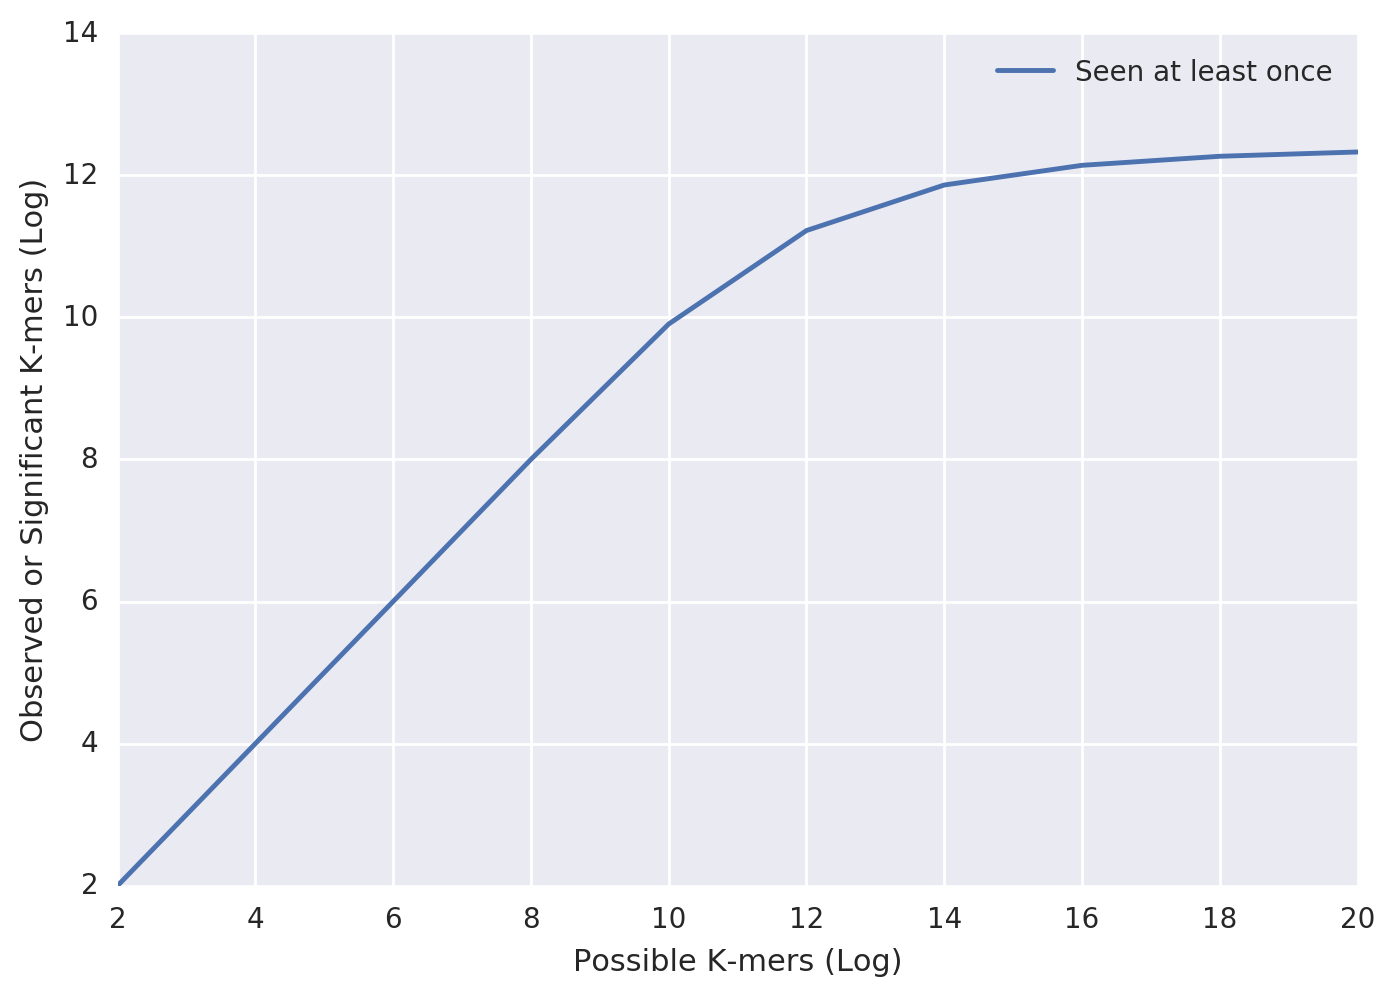

In [217]:
plt.plot(np.log2(total_possible_list), 
         np.log2(num_observed_list),
         label='Seen at least once'
            )
# plt.plot(np.log2(total_possible_list), 
#             np.log2(num_significant_list),
#             label='Signficant')
plt.legend()
plt.xlabel('Possible K-mers (Log)')
plt.ylabel('Observed or Significant K-mers (Log)')


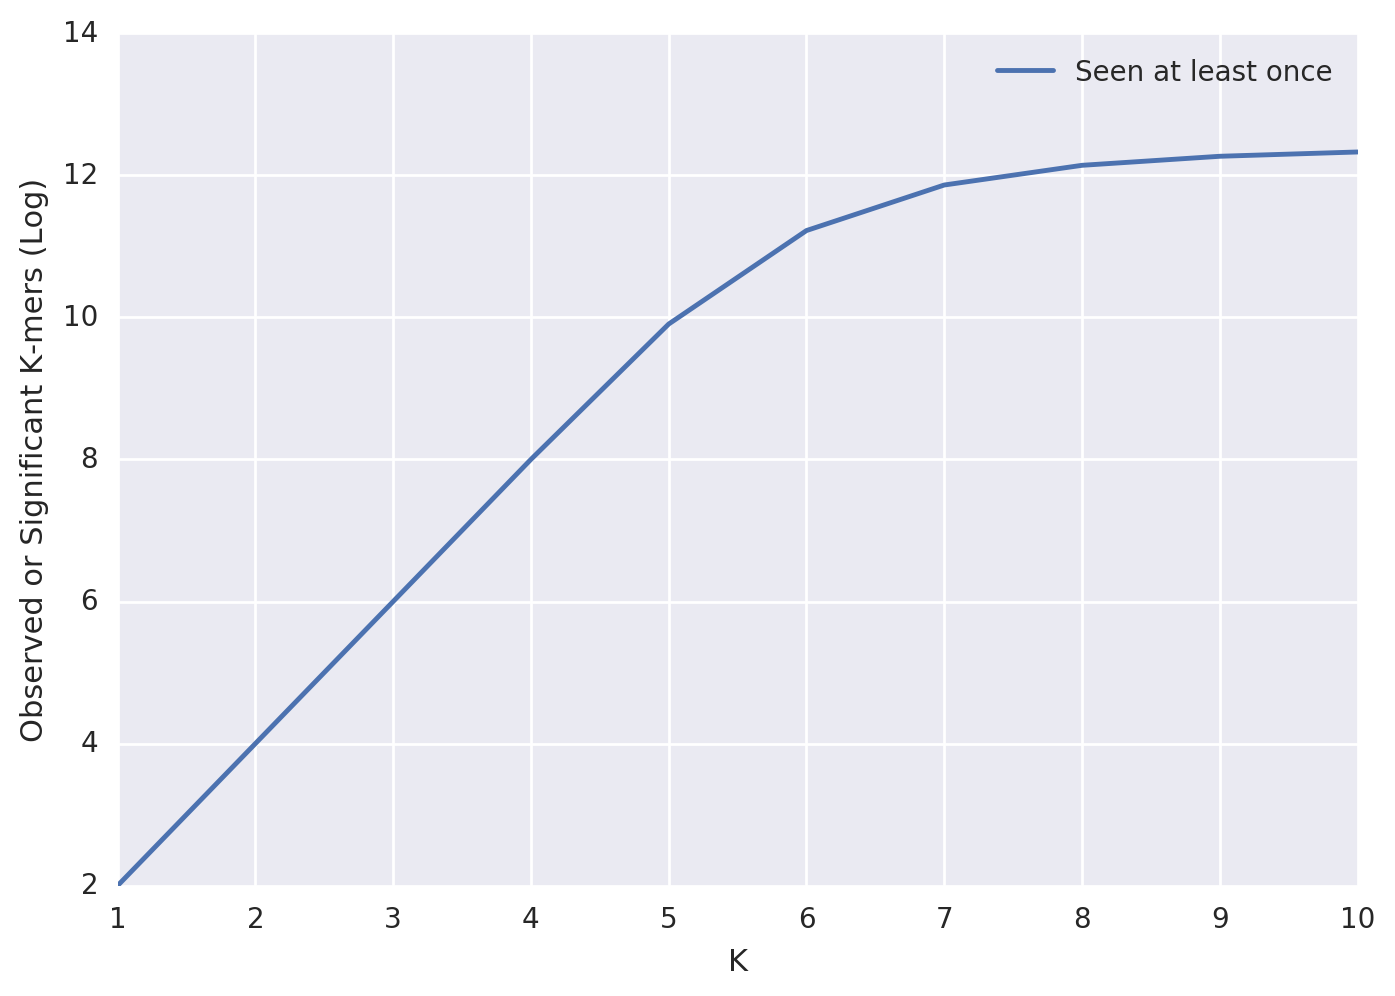

In [218]:
plt.plot(k_list, 
         np.log2(num_observed_list),
         label='Seen at least once'
            )
# plt.plot(k_list, 
#             np.log2(num_significant_list),
#             label='Signficant')
plt.legend()
plt.xlabel('K')
plt.ylabel('Observed or Significant K-mers (Log)')

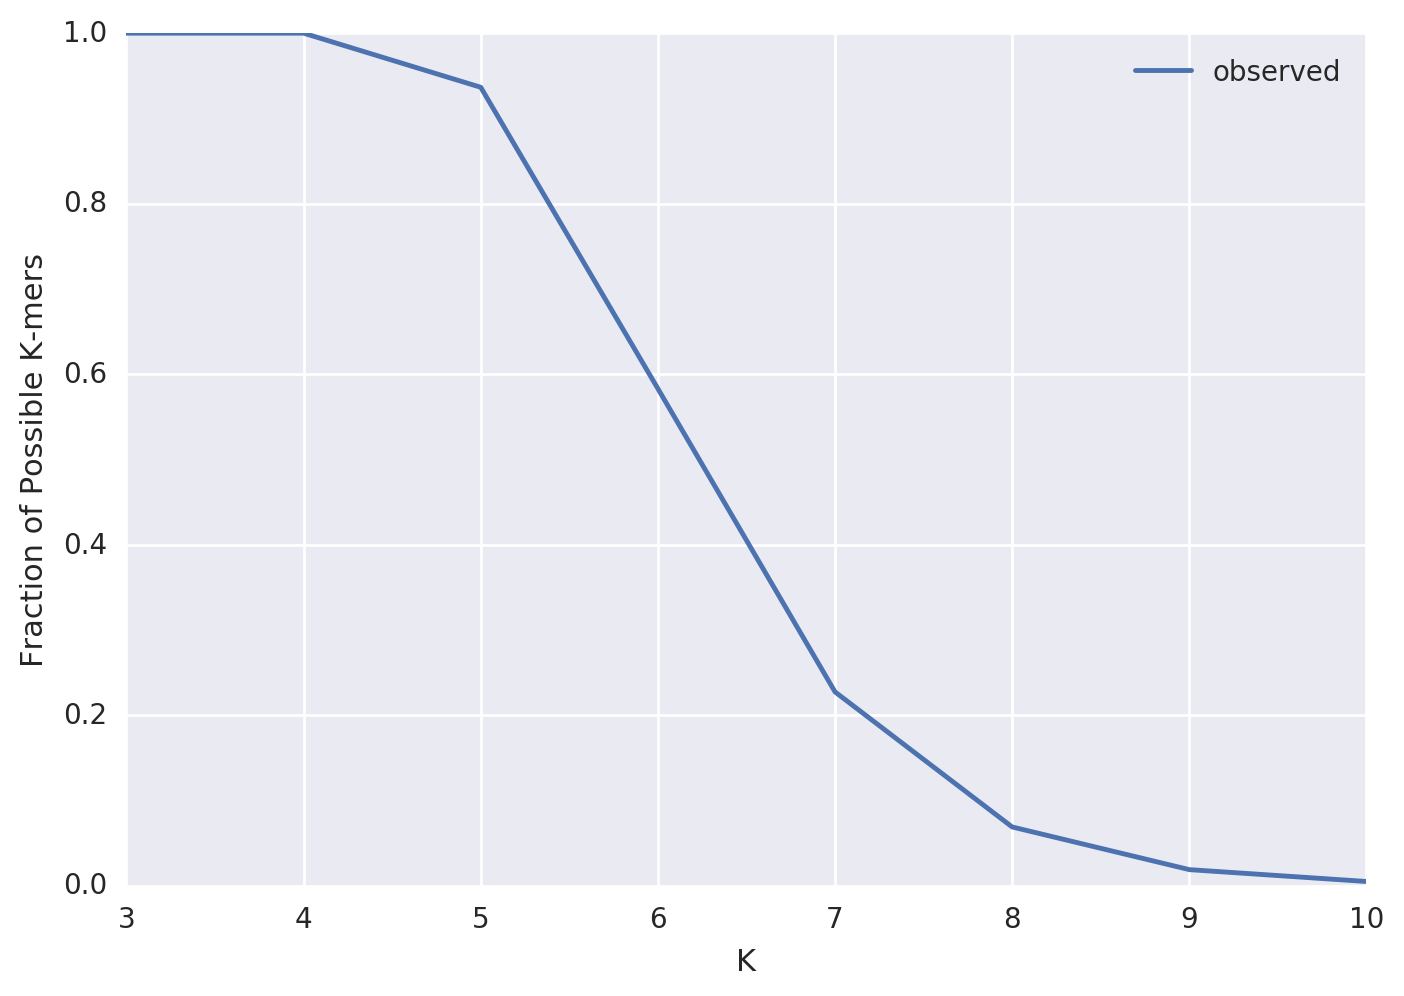

In [220]:
observed_fractions = np.array(num_observed_list)/np.array(total_possible_list)
significant_fractions = np.array(num_significant_list)/np.array(total_possible_list)
plt.plot(k_list, 
         observed_fractions,
         label='observed'
            )
# plt.plot(k_list, 
#          significant_fractions,
#          label='significant'
#             )
plt.legend()
plt.xlim(3,10)
plt.xlabel('K')
plt.ylabel('Fraction of Possible K-mers')



/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


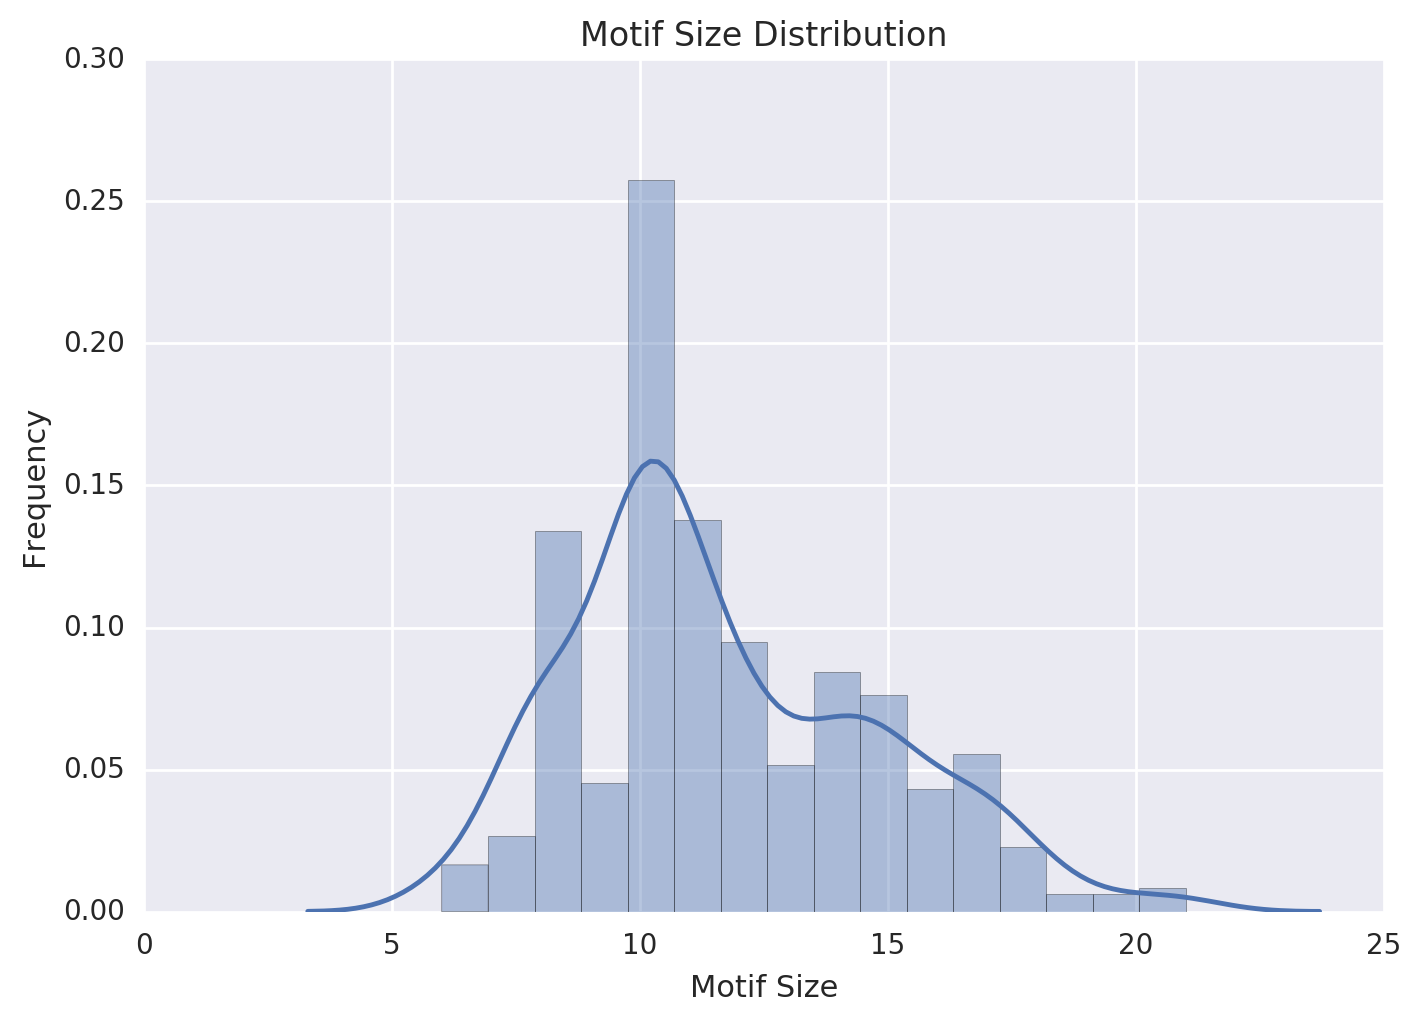

In [177]:
sns.distplot([len(motif_matrix_dict[x]) for x in motif_matrix_dict.keys()])
plt.ylabel('Frequency')
plt.xlabel('Motif Size')
plt.title('Motif Size Distribution')

## Distribution of K-mer counts

In [159]:
threshold = 0.3
pos_nuc_dict = dict(zip(range(4),['A', 'C', 'G', 'T']))
max_kmer_size = 10
count_list = []
k_list = []
normed_count_list = []
for kmer_target_length in range(1,max_kmer_size+1):
    print('looking at ' + str(kmer_target_length)+'-mers')
    num_possible = np.power(4,kmer_target_length)
    total_kmers.append(num_possible)
    k.append(kmer_target_length)
    kmers = []
    for motif_name in sorted(motif_matrix_dict.keys()):
        current_motif = motif_matrix_dict[motif_name]
        current_nucs = []
        kmer_length = np.min([len(current_motif), kmer_target_length])
        for pwm_pos in range(len(current_motif)):
            significant_nucs = []
            current_freqs = current_motif[pwm_pos]
            if current_freqs[0] >= threshold:
                significant_nucs.append('A')
            if current_freqs[1] >= threshold:
                significant_nucs.append('C')
            if current_freqs[2] >= threshold:
                significant_nucs.append('G')
            if current_freqs[3] >= threshold:
                significant_nucs.append('T')
            current_nucs.append(significant_nucs)
            if len(current_nucs) == kmer_length:
                current_kmers = itertools.product(*current_nucs)
                for km in current_kmers:
                    kmers.append(''.join(km))
                current_nucs = current_nucs[1:] # increment sliding window
    motif_counts = Counter(kmers)
    count_values = list(motif_counts.values())
    k_list = k_list + [kmer_target_length] * len(count_values)
    count_list = count_list + count_values
    normed_count_list = normed_count_list + list(scipy.stats.zscore(count_values))

looking at 1-mers
looking at 2-mers
looking at 3-mers
looking at 4-mers
looking at 5-mers
looking at 6-mers
looking at 7-mers
looking at 8-mers
looking at 9-mers
looking at 10-mers


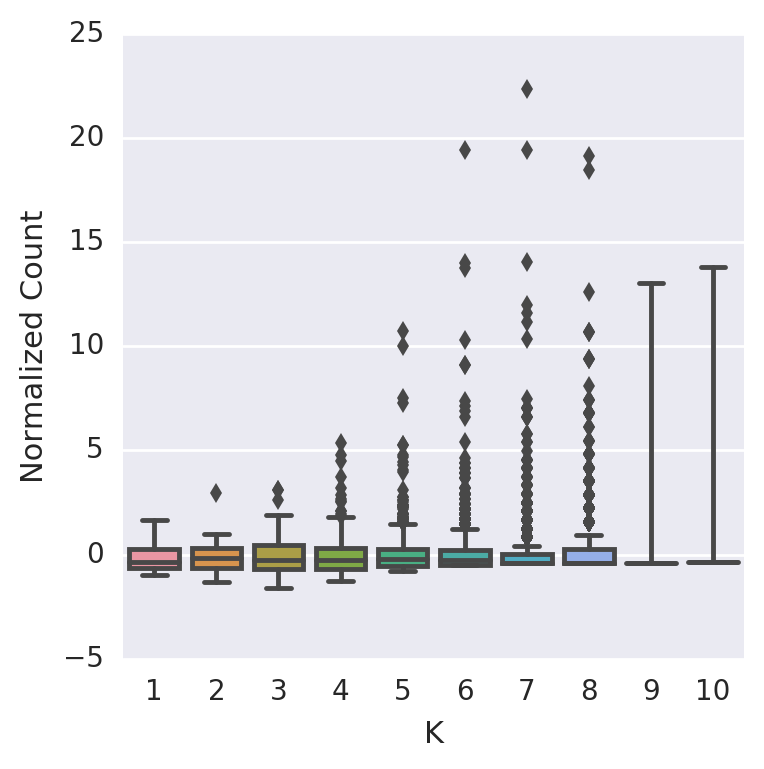

In [161]:
frame = pd.DataFrame({'K':k_list,
                     'Count':count_list,
                     'Normalized Count':normed_count_list,
                      'Log Count':np.log2(np.array(count_list) + 1)
                      })
sns.factorplot(data = frame, 
             x = 'K',
             y = 'Normalized Count',
             kind='box')

## Inferring K-mer Order Maps

In [94]:
from numba import jit

In [200]:
def calculate_orderMap(seq, 
                       k,
                       kmer_index_dict,
                       window_overlap = 0,
                       interaction_distance = 200,
                       verbose = False
                       ):
    num_kmers = len(kmer_index_dict)
    interaction_matrix = np.zeros((num_kmers,num_kmers))
    if verbose:
        print('reading', seq, len(seq))
    seenKmers = [] # ordered list of k-mers encountered
    for frame in range(k):
        if verbose:
            print('frame', frame)
        move_increment = (k - window_overlap)
        numWindows = int(np.floor((len(seq) - k - frame)/move_increment)) + 1
        if verbose:
            print('numWindows', numWindows)
        for i in range(numWindows):
            startingPos =  frame + i * move_increment
            currentKmer = seq[startingPos:startingPos + k]
            if verbose:
                print(startingPos, startingPos + k, currentKmer)
            if not 'N' in currentKmer:
                # update interaction matrix
                for skmt in seenKmers:
                    skm = skmt[0]
                    skm_start = skmt[1]
                    # if the seen k-mer follows the current k-mer
                    if skm_start < startingPos:
                        distance = startingPos - (skm_start + k)
                        if distance <= interaction_distance and distance >= ( -1 *window_overlap):
                            skm_index = kmer_index_dict[skm] # row index
                            currentKmer_index = kmer_index_dict[currentKmer] # col index
                            interaction_matrix[skm_index][currentKmer_index] +=1
                            if verbose:
                                print(skm, '->', currentKmer, distance)
                # update seenKmers
                seenKmers.append((currentKmer, startingPos))
    
    return interaction_matrix


In [377]:
@jit(nopython=False,cache=True)
def calculate_orderMap_numba(seq, 
                       k,
                       kmer_index_dict,
                       window_overlap = 0,
                       interaction_distance = 200,
                       verbose = False
                       ):
    num_kmers = len(kmer_index_dict)
    interaction_matrix = np.zeros((num_kmers,num_kmers), dtype=np.int32)
    seenKmers = None # ordered list of k-mers encountered
    for frame in range(k):
        move_increment = (k - window_overlap)
        numWindows = int(np.floor((len(seq) - k - frame)/move_increment)) + 1
        for i in range(numWindows):
            startingPos =  frame + i * move_increment
            currentKmer = seq[startingPos:startingPos + k]
            if not 'N' in currentKmer:
                # update interaction matrix
                if not seenKmers == None:
                    for skmt in seenKmers:
                        skm = skmt[0]
                        skm_start = skmt[1]
                        # if the seen k-mer follows the current k-mer
                        if skm_start < startingPos:
                            distance = startingPos - (skm_start + k)
                            if distance <= interaction_distance and distance >= ( -1 *window_overlap):
                                skm_index = kmer_index_dict[skm] # row index
                                currentKmer_index = kmer_index_dict[currentKmer] # col index
                                interaction_matrix[skm_index][currentKmer_index] +=1
                # update seenKmers
                    seenKmers.append((currentKmer, startingPos))
                else:
                    seenKmers = [(currentKmer, startingPos)]


    return interaction_matrix



In [378]:
def calculate_kmerOrderMap(id_sequence_dict, 
                           k, 
                           window_overlap = 0,
                           interaction_distance = 200,
                           verbose=False):
    ids = sorted(id_sequence_dict.keys())
    sequences = [id_sequence_dict[x] for x in ids]
    orderMaps = []
    
    # initialize kmer indices
    kmer_index_dict = {}
    counter = 0
    for kmer in itertools.product(['A', 'C', 'G', 'T'], repeat=k):
        kmer_string = ''.join(kmer)
        kmer_index_dict[kmer_string] = counter
        counter += 1
    # loop through sequences
    for seq in sequences:
        orderMap = calculate_orderMap(seq,
                                      k,
                                      kmer_index_dict,
                                      window_overlap = window_overlap,
                                      interaction_distance = interaction_distance,
                                      verbose=verbose)
        orderMaps.append(orderMap)
    return ids, orderMaps, kmer_index_dict

### Timing Tests

In [246]:
test_dict = dict(zip(range(3),['AAACCCGGGTTT', # 3-mers no overlap
                  'AAAACCCGGGTTT', # for 3-mers second frame \
                  'ATATATATATAT' # 3-mers  1 overlap
                  ]))
test_dict = dict(zip(range(1),['AAACCCGGGTTT', # 3-mers no overlap
                 
                  ]))

In [247]:
numseq_list = []
numproc_list = []
time_list = []
for numSequences in [1, 10, 100, 1000]:
    peak_indices = summary_frame[summary_frame['c57bl6_atf3_veh'] > 0.0].index.values[:numSequences]
    peak_sequences = [target_sequence_dict[x] for x in peak_indices]
    background_indices = list(background_sequence_dict.keys())[:len(peak_indices)]
    background_sequences = [background_sequence_dict[x][:numSequences] for x in background_indices]

    test_dict = dict(zip(np.concatenate([peak_indices, background_indices]),
                    np.concatenate([peak_sequences, background_sequences])))
    start = time.time()
    ids, orderMaps, kmer_index_dict = calculate_kmerOrderMap(test_dict, 
                           k=3, 
                           window_overlap = 0,
                           interaction_distance = 10,
                           verbose = False
                           )
    end = time.time()
    numseq_list.append(numSequences)
    time_list.append(end-start)
    print(end-start, numSequences)

0.005196094512939453 1
0.03336668014526367 10
0.44043636322021484 100
7.572418689727783 1000


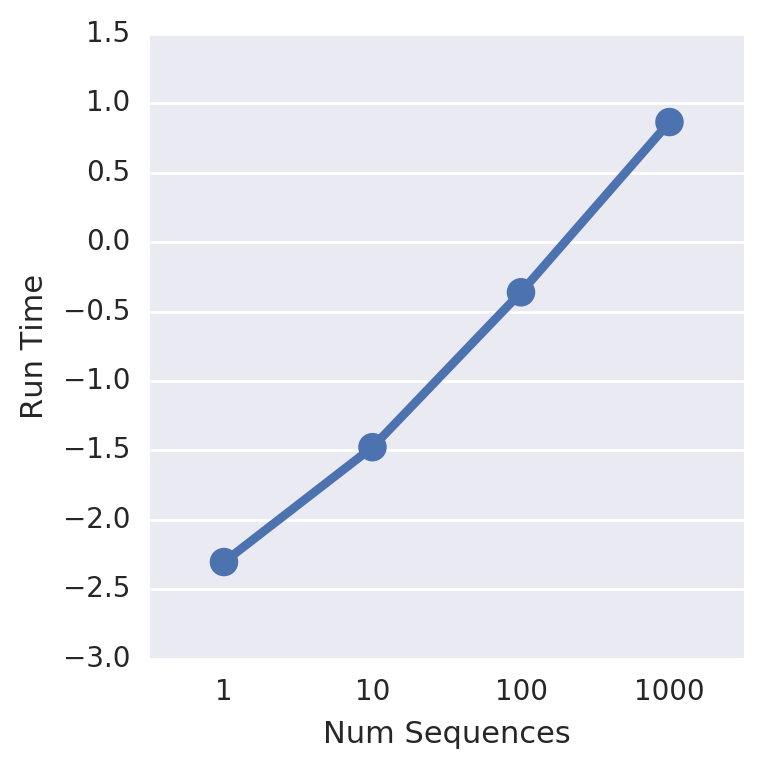

In [223]:
time_frame = pd.DataFrame({'Run Time': np.log10(np.array(time_list)),
                           'Num Sequences': numseq_list})
sns.factorplot(data = time_frame,
               x = 'Num Sequences',
               y = 'Run Time',
              )


### K=3, window_overlap=0, interaction_distance=1

In [380]:
target_ids, target_order_maps, kmer_index_dict = calculate_kmerOrderMap(target_sequence_dict, 
                           k=3, 
                           window_overlap = 0,
                           interaction_distance = 1,
                           verbose = False
                           )

current_background_sequence_dict = {x:background_sequence_dict[x] for x in list(background_sequence_dict.keys())[:len(target_sequence_dict)]}

background_ids, background_order_maps, kmer_index_dict = calculate_kmerOrderMap(current_background_sequence_dict, 
                           k=3, 
                           window_overlap = 0,
                           interaction_distance = 1,
                           verbose = False
                           )

In [382]:
# flatten maps and combine target and background sequences
flattened_dict = {}
for i in range(len(target_order_maps)):
    current_id = target_ids[i]
    flattened_dict[current_id] = target_order_maps[i].flatten()
for i in range(len(background_order_maps)):
    current_id = background_ids[i]
    flattened_dict[current_id] = background_order_maps[i].flatten()

index_kmer_dict = {kmer_index_dict[x]:x for x in kmer_index_dict}

flatIndex_transition_dict = {}
transition_flatIndex_dict = {}
counter = 0
for i in range(len(kmer_index_dict)):
    for j in range(len(kmer_index_dict)):
        kmer1 = index_kmer_dict[i]
        kmer2 = index_kmer_dict[j]
        flatIndex_transition_dict[counter] = kmer1 + '->' + kmer2
        transition_flatIndex_dict[kmer1 + '->' + kmer2] = counter
        counter += 1
        
data_frame = pd.DataFrame(flattened_dict).T
data_frame.columns = [flatIndex_transition_dict[x] for x in data_frame.columns.values]

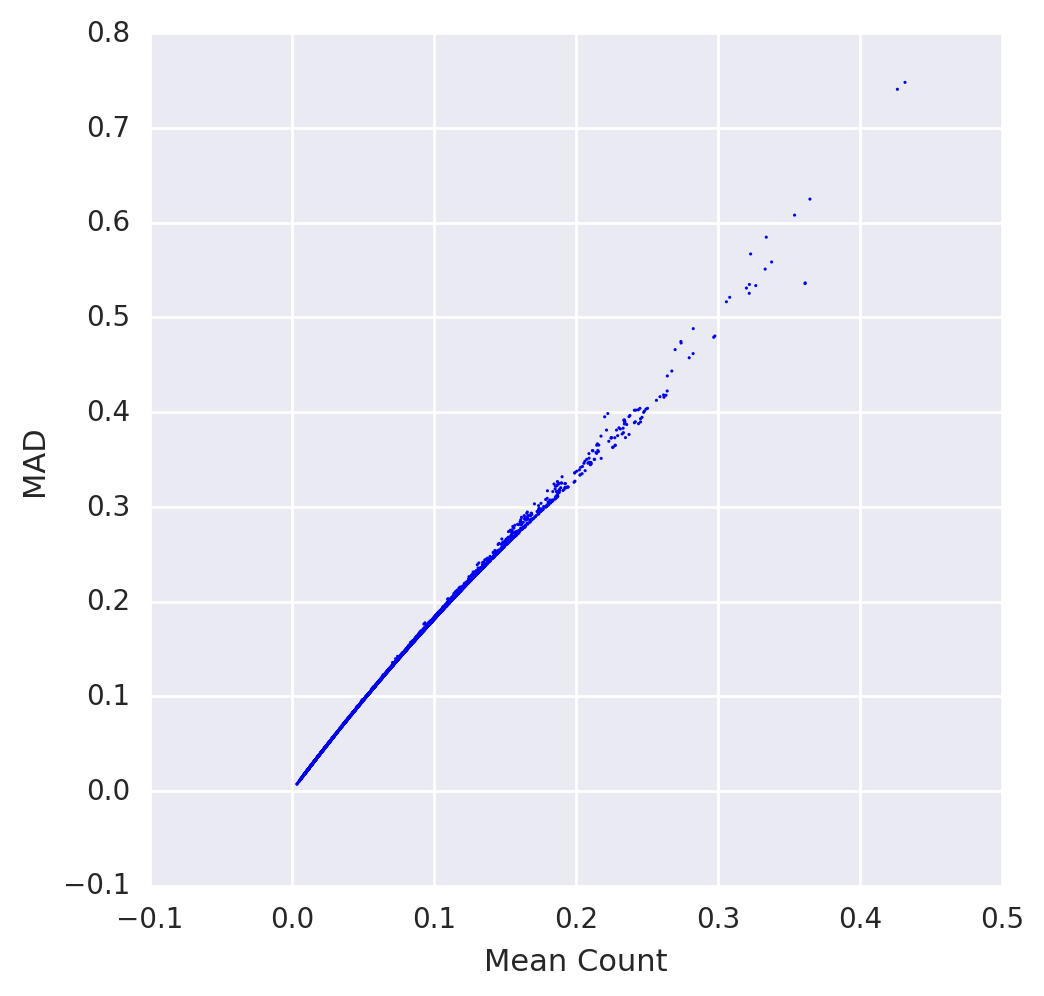

In [392]:
means = data_frame.mean(axis=0)
mads = data_frame.mad(axis=0)
labels = data_frame.index.values

plt.scatter(means,
            mads,
            marker = '.',
            edgecolor = 'None',
            s = 5
           )
# for i in range(len(means)):
#     if means[i] > mads[i]:
#         plt.annotate(xy=(means[i], mads[i]), s=labels[i])
# plt.plot([0,1],[0,1])
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.xlabel('Mean Count')
plt.ylabel('MAD')
ax = plt.gca()
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
# plt.text(x=0.0, y=-0.2, s='No transition enriched when looking at entire data set - no bias', size=10)



#### PCA on all data

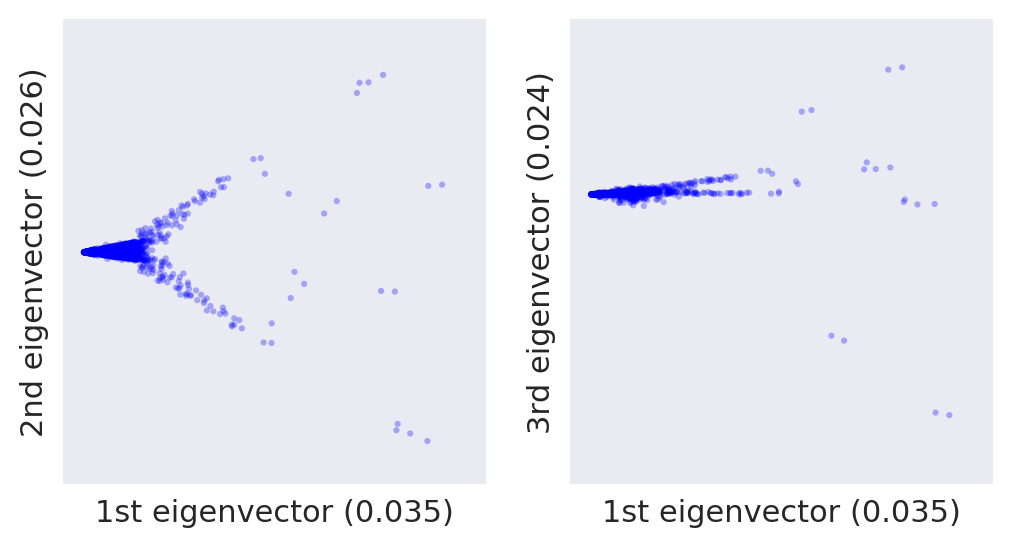

In [390]:
features = data_frame
# colors = ['red'] * numSequences + ['blue'] * numSequences

model = sklearn.decomposition.PCA()
reduced_features = model.fit_transform(features.T)
explained_variance_ratios = model.explained_variance_ratio_

f, axs = plt.subplots(1,2, figsize=(6,3))
plt.subplot(1,2,1)  
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], s=5, c=colors, edgecolor='None', alpha=0.3)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])

plt.subplot(1,2,2)  
plt.scatter(reduced_features[:, 0], reduced_features[:, 2], s=5, c=colors, edgecolor='None', alpha=0.3)
plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
plt.yticks([])
plt.show()

In [403]:
for factor in ['atf3', 'cjun', 'junb', 'jund', 'cebpa', 'pu1']:
    for treatment in ['veh', 'kla']:
        current_target_ids = summary_frame[summary_frame['c57bl6_' + factor + '_' + treatment] > 0.0].index.values
        
        target_features = data_frame[data_frame.index.isin(current_target_ids)]
        background_features = data_frame[data_frame.index.isin(background_ids)]
        
        target_mads = target_features.mad(axis=0)
        target_means = target_features.mean(axis=0)
        
        print(np.sum(target_means > target_mads))
        

#         background_mads = np.mean(background_feaures)
#         for transition in target_features.columns:
            



0
0
0
0
0
0
0
0
0
0
0
0


In [399]:
target_features.mad(axis=0)

AAA->AAA    0.914060
AAA->AAC    0.217336
AAA->AAG    0.331382
AAA->AAT    0.226438
AAA->ACA    0.314195
AAA->ACC    0.192218
AAA->ACG    0.060396
AAA->ACT    0.198398
AAA->AGA    0.355709
AAA->AGC    0.219907
AAA->AGG    0.375942
AAA->AGT    0.174906
AAA->ATA    0.214194
AAA->ATC    0.147567
AAA->ATG    0.234051
AAA->ATT    0.166285
AAA->CAA    0.299999
AAA->CAC    0.220586
AAA->CAG    0.337576
AAA->CAT    0.169274
AAA->CCA    0.275668
AAA->CCC    0.215503
AAA->CCG    0.063248
AAA->CCT    0.184669
AAA->CGA    0.049929
AAA->CGC    0.053107
AAA->CGG    0.067977
AAA->CGT    0.046031
AAA->CTA    0.139335
AAA->CTC    0.177495
              ...   
TTT->GAG    0.208401
TTT->GAT    0.119697
TTT->GCA    0.187703
TTT->GCC    0.145777
TTT->GCG    0.035334
TTT->GCT    0.221190
TTT->GGA    0.171750
TTT->GGC    0.130176
TTT->GGG    0.209112
TTT->GGT    0.174810
TTT->GTA    0.136258
TTT->GTC    0.158732
TTT->GTG    0.198537
TTT->GTT    0.275076
TTT->TAA    0.257022
TTT->TAC    0.131482
TTT->TAG    0

#### PCA on all transitions for each factor

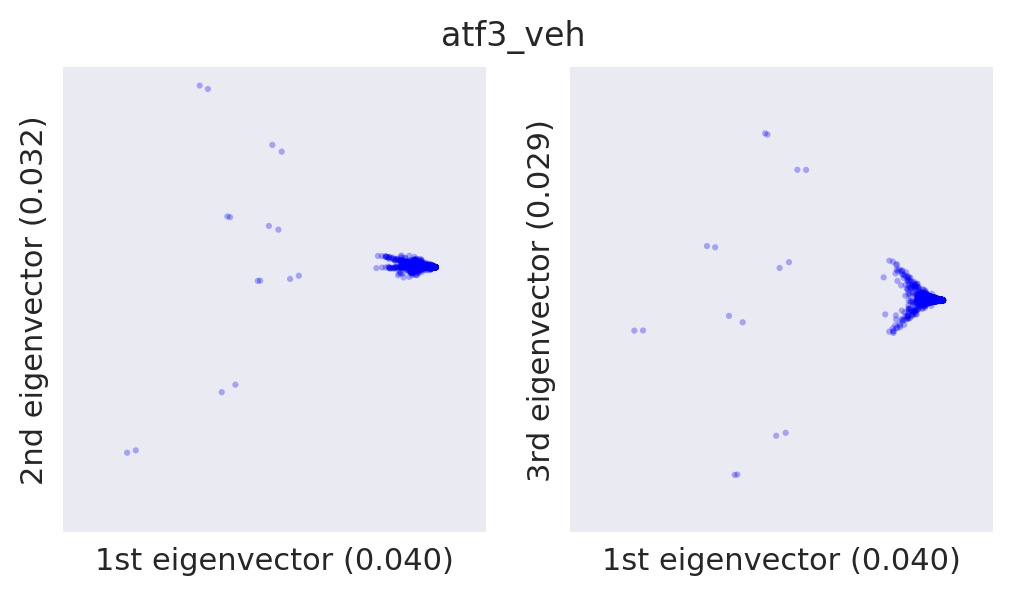

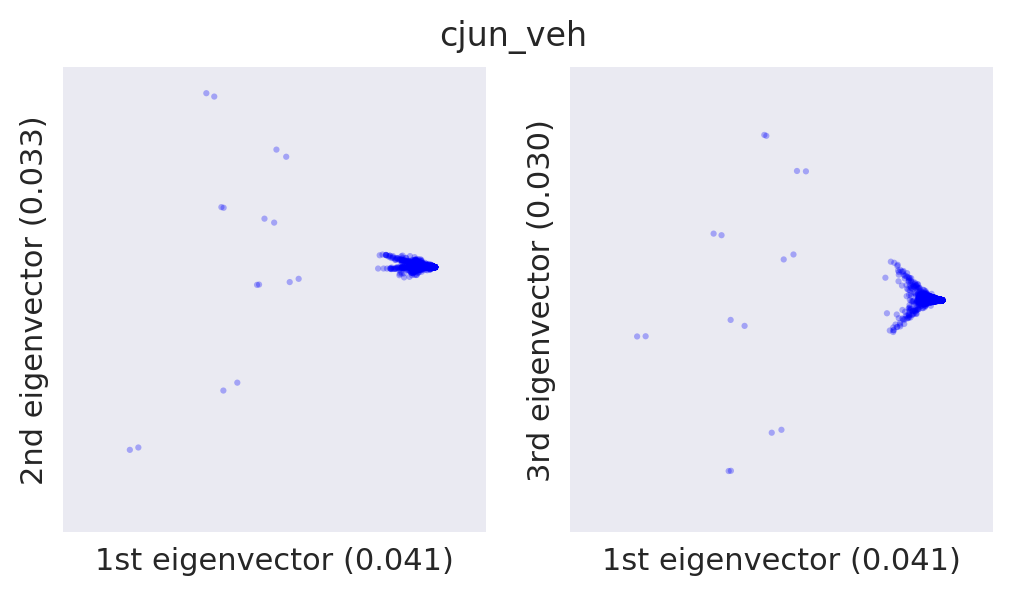

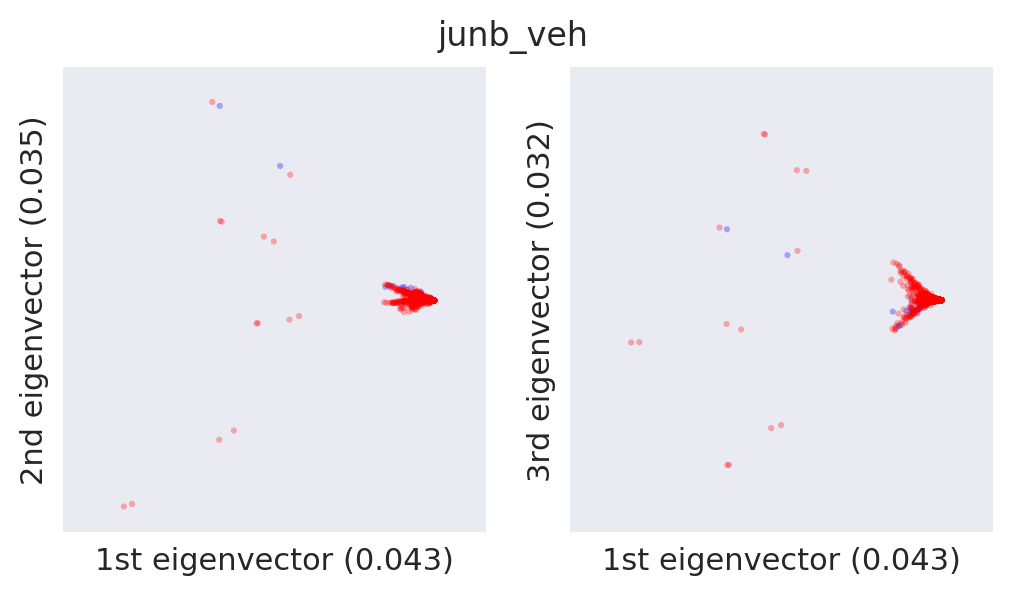

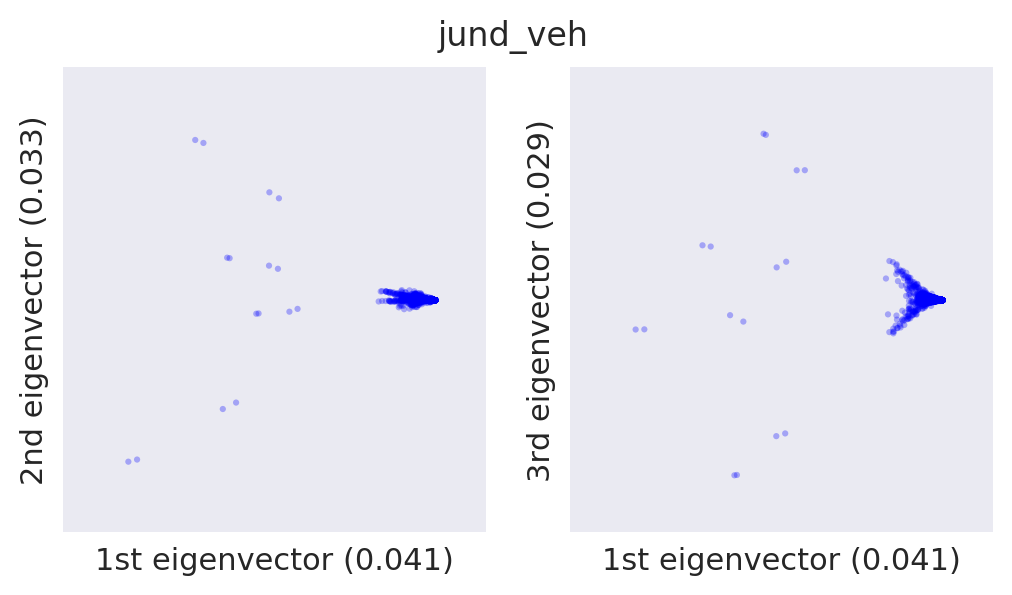

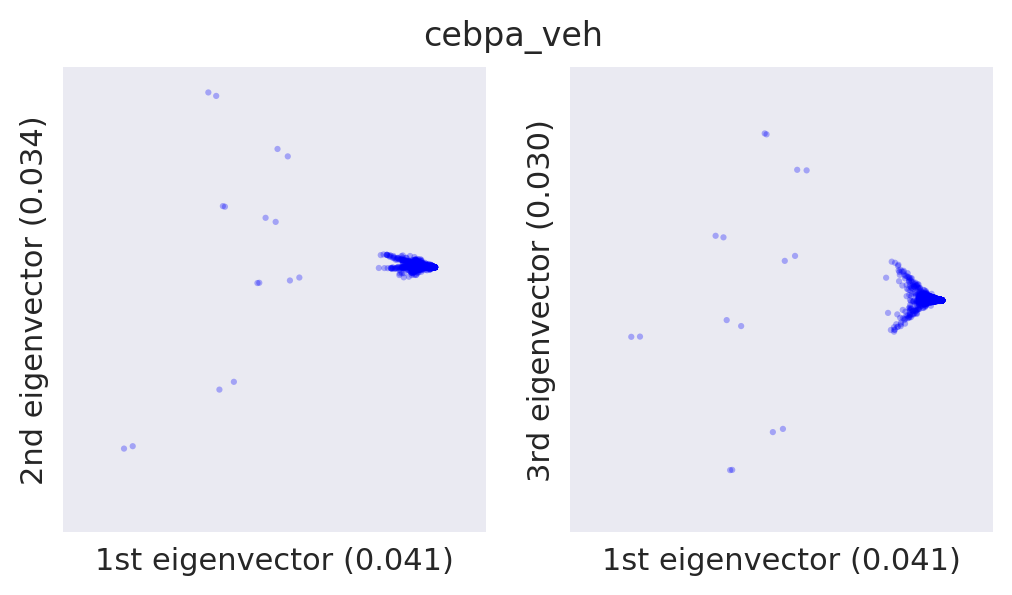

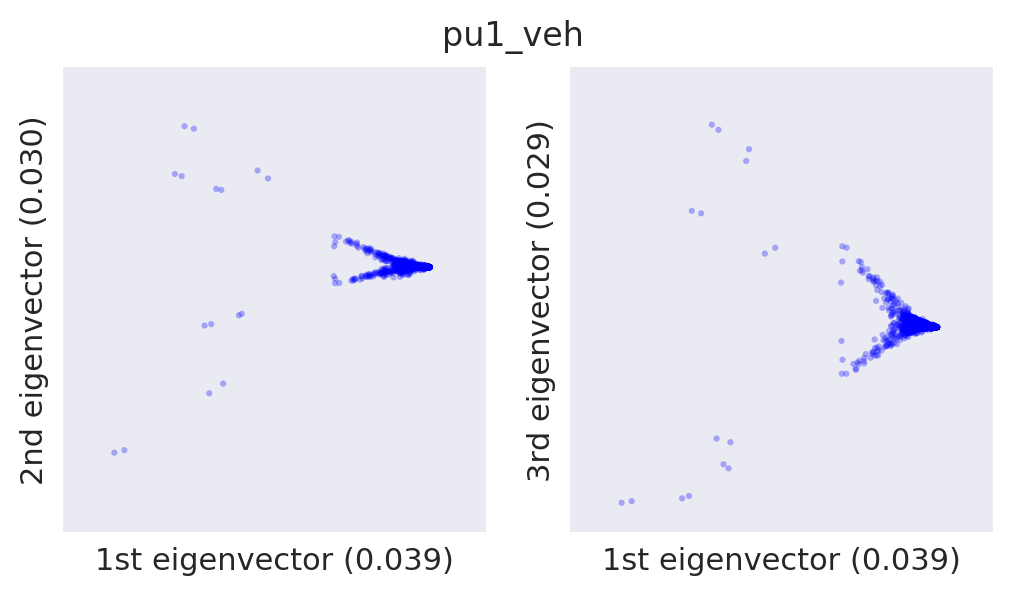

In [388]:
for factor in ['atf3', 'cjun', 'junb', 'jund', 'cebpa', 'pu1']:
    for treatment in ['veh']:
        current_target_ids = summary_frame[summary_frame['c57bl6_' + factor + '_' + treatment] > 0.0].index.values
        
        target_features = data_frame[data_frame.index.isin(current_target_ids)]
        background_features = data_frame[data_frame.index.isin(background_ids)]
        features = pd.concat([target_features, background_features])
        
        model = sklearn.decomposition.PCA()
        reduced_features = model.fit_transform(features.T)
        explained_variance_ratios = model.explained_variance_ratio_
        
        colors = ['blue' if x in target_features.index.values else 'red' for x in features.index.values]
        f, axs = plt.subplots(1,2, figsize=(6,3))
        plt.subplot(1,2,1)  
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], s=5, c=colors, edgecolor='None', alpha=0.3)

        plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
        plt.xticks([])
        plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
        plt.yticks([])

        plt.subplot(1,2,2)  
        plt.scatter(reduced_features[:, 0], reduced_features[:, 2], s=5, c=colors, edgecolor='None', alpha=0.3)
        plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
        plt.xticks([])
        plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
        plt.yticks([])
        plt.suptitle(factor + '_' + treatment)
        plt.show()

## multiprocessor experiments